# Traffic Flow Simulator

In [9]:
from utils import Agent, Road, read_config, Trpf
from itertools import repeat, compress
from altair import Chart
import numpy as np
import pandas as pd

## Functions

In [10]:
def get_route_choices(agents, route_count):
    choices = np.array(list(map(lambda agent: agent.choose_route(), agents)))
    route_traveller_counts = np.bincount(choices, minlength = route_count)[:, np.newaxis]
    
    return choices, route_traveller_counts

def get_route_costs(roads, choices, route_traveller_counts):
    road_traveller_counts = np.array(route_to_road * route_traveller_counts)
    list(map(lambda count, road: road.add_travellers(count), road_traveller_counts[:,0], roads))
    road_costs = np.array(list(map(lambda road: road.report_cost(), roads)))[:, np.newaxis]
    route_costs = np.array(road_to_route * road_costs)
    return route_costs

def give_costs(agents, choices, route_costs):    
    list(map(lambda agent, choice: agent.recieve_travel_cost(route_costs[choice,0]), agents, choices))
    
def get_reports(agents, trpf, choices, excess_traveller_counts):
    reports = list(map(lambda agent, choice, excess: agent.report_congestion(excess[choice,0]),\
        agents, choices, repeat(excess_traveller_counts)))
    list(map(lambda route, report: trpf.recieve_report(route, report), choices, reports))
    
def give_trpfs(trpf_agents, route_trpfs):
    list(map(lambda agent, trpf: agent.recieve_trpf(trpf), trpf_agents, repeat(route_trpfs)))

## Read the configuration

In [14]:
simulation_folder = '/home/ihsan/Research/TrafficFlowSimulator/simulations/OWNet/'
traffic_file = simulation_folder + 'traffic.properties'
roadnet_file = simulation_folder + 'roadnet.csv'

config = read_config(traffic_file, roadnet_file)

tresholds = config['tresholds']
weights = config['weights']
trpf_use_percent = config['trpf_use_percent']
t = config['t']
agent_counts = config['agent_counts']
change_percent = config['change_percent']
routes = config['routes']
route_opts = config['route_opts']
round_count = config['round_count']
road_params = config['road_params']
print('Tresholds: {}'.format(tresholds))
print('Weights: {}'.format(weights))
print('Trpf Use Percent: {}'.format(trpf_use_percent))
print('T: {}'.format(t))
print('Agent Counts by Trip: {}'.format(agent_counts))
print('Change Percent: {}'.format(change_percent))
#print('Tresholds: {}'.format(routes))
print('Route Optimums by Trip: {}'.format(route_opts))
print('Round Count: {}'.format(round_count))

Tresholds: [10, 20, 50]
Weights: [3, 5, 7]
Trpf Use Percent: 1.0
T: 3
Agent Counts by Trip: [600, 400, 300, 400]
Change Percent: 0.2
Route Optimums by Trip: {0: [0, 109, 376, 0, 0, 0, 145, 0], 1: [0, 0, 0, 154, 25, 154, 0, 0], 2: [0, 41, 0, 0, 0, 0, 0, 0], 3: [340, 84, 0, 0, 0, 0, 0, 272]}
Round Count: 100


## Initialize the simulation

In [23]:
trips = np.hstack([np.ones(agent_counts[i])*i for i in range(len(agent_counts))])

trpf = Trpf(routes, round_count, t)

roads = []
road_inds = {}
for i, params in enumerate(road_params.itertuples(index=False)):
    road = Road(*params)
    roads.append(road)
    road_name = params[0] + params[1] # Node 1 + Node 2
    road_inds[road_name] = i
    
agents = []
trpf_agents = []
for tag, trip in zip(range(sum(agent_counts)), trips):
    agent = Agent(tag, tresholds, weights, trip, routes, change_percent, trpf_use_percent)
    agents.append(agent)
    if agent.uses_trpf():
        trpf_agents.append(agent)

route_to_road = {i[0] : np.zeros((len(roads), len(i[1]))) for i in routes.items()}
for trip, trip_routes in routes.items():
    for i, route in enumerate(trip_routes):
        #print(routes)
        for e in range(1, len(route)):
            try:
                road_name = route[e-1] + route[e]
                j = road_inds[road_name]
            except KeyError:
                road_name = route[e] + route[e-1]
                j = road_inds[road_name]
                
            route_to_road[trip][j, i] = 1
        
route_to_road = {i[0]: np.matrix(i[1]) for i in routes.items()}
road_to_route = {i[0]: i[1].T for i in route_to_road.items()}
route_counts = {i[0]: len(i[1]) for i in road_to_route.items()}

data = pd.DataFrame(columns = ['Route', 'Count', 'Cost', 'Trpf', 'Round'])

print('Number of trpf users: {}, Number of routes by trip: {}, Number of roads:{}'.format(len(trpf_agents),\
    route_counts, len(roads)))

Number of trpf users: 1700, Number of routes by trip: {0: 8, 1: 8, 2: 8, 3: 8}, Number of roads:24


## Simulation

In [6]:
while trpf.start_new_round():
    choices, route_traveller_counts = get_route_choices(agents, route_count)
    excess_traveller_counts = np.absolute(route_traveller_counts - route_opts)
    
    route_costs = get_route_costs(roads, choices, route_traveller_counts)
    give_costs(agents, choices, route_costs)    
    get_reports(agents, trpf, choices, excess_traveller_counts)
    
    route_trpfs = trpf.calculate_trpf()
    give_trpfs(trpf_agents, route_trpfs)
   
    # Save the choices
    for route in range(route_count):
        route_cost = route_costs[route,0]
        route_trpf = route_trpfs[route]
        route_traveller_count = route_traveller_counts[route,0]
        
        data.loc[data.shape[0]] = [route, route_traveller_count, route_cost, route_trpf, trpf.current_round]

## Visualizations

### Statistics

In [7]:
# Drop the first 200 rounds, Trpf and Round Columns
data['TotalCost'] = data.Count * data.Cost
data_by_routes = data.drop(['Round', 'Trpf'], axis=1).groupby('Route')

means = data_by_routes.mean()
means.columns = ['CountMean', 'CostMean', 'TotalCostMean']

stds = data_by_routes.std()
stds.columns = ['CountStd', 'CostStd', 'TotalCostStd']

report = pd.concat([means, stds], axis=1)
report = report[['CountMean', 'CountStd', 'CostMean', 'CostStd', 'TotalCostMean', 'TotalCostStd']]

report

,CountMean,CountStd,CostMean,CostStd,TotalCostMean,TotalCostStd
Route,,,,,,
0.0,42.735,7.604863,50.0000,0.000000,2136.7500,380.243161
1.0,22.055,10.724132,55.7265,0.760486,1224.4480,569.008844
2.0,135.210,16.288106,49.2475,2.304920,6695.5065,984.713504


### Agent Count per Route over Time

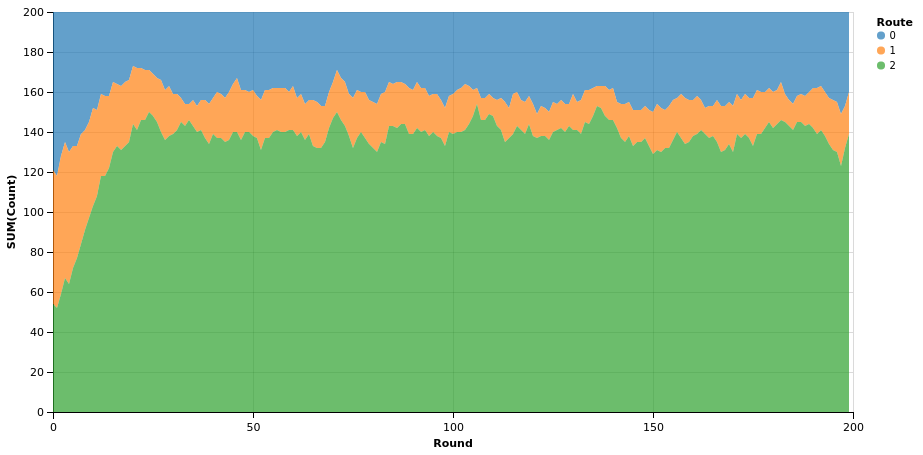

In [8]:
chart = Chart(data).mark_area().encode(x='Round:Q', y='sum(Count):Q', color='Route:N')
chart.configure_cell(height=400, width=800)

### Cost per Agent per Route over Time

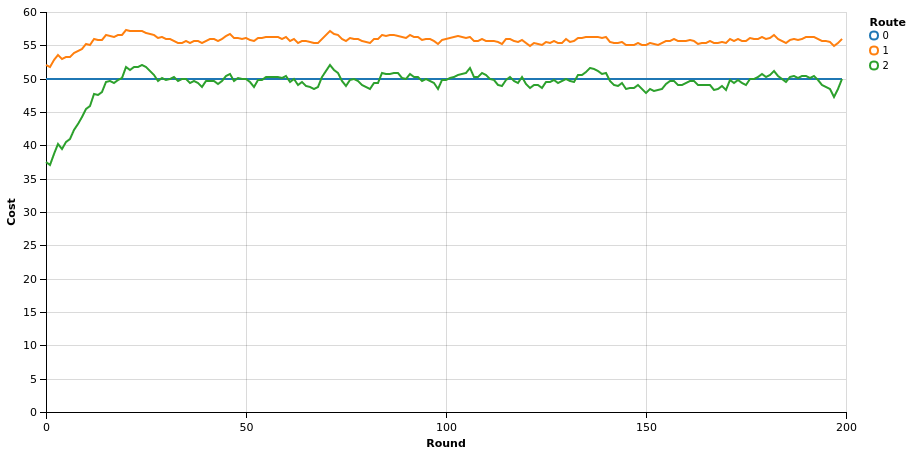

In [9]:
chart = Chart(data).mark_line().encode(x='Round:Q', y='Cost:Q', color='Route:N')
chart.configure_cell(height=400, width=800)

### Total Cost over Time

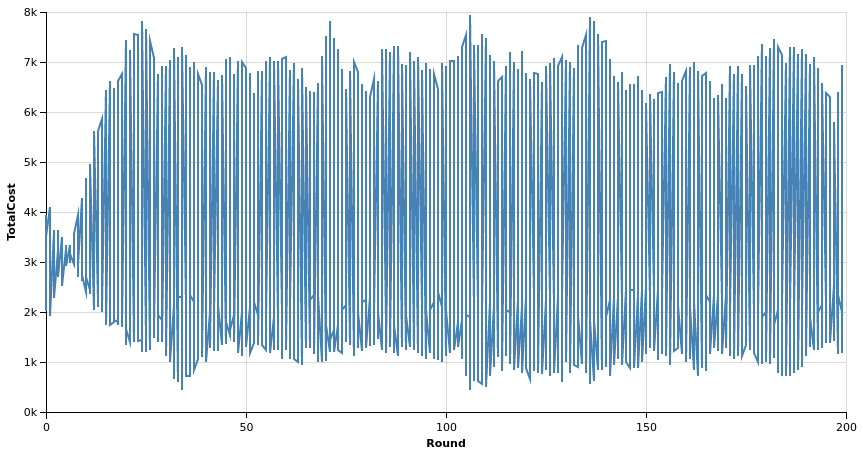

In [10]:
chart = Chart(data).mark_line().encode(x='Round:Q', y='TotalCost:Q')
chart.configure_cell(height=400, width=800)

In [11]:
data_by_routes.sum() # Total cost can get as low as 50

,Count,Cost,TotalCost
Route,,,
0.0,8547.0,10000.0,427350.0
1.0,4411.0,11145.3,244889.6
2.0,27042.0,9849.5,1339101.3


### Trpf over Time

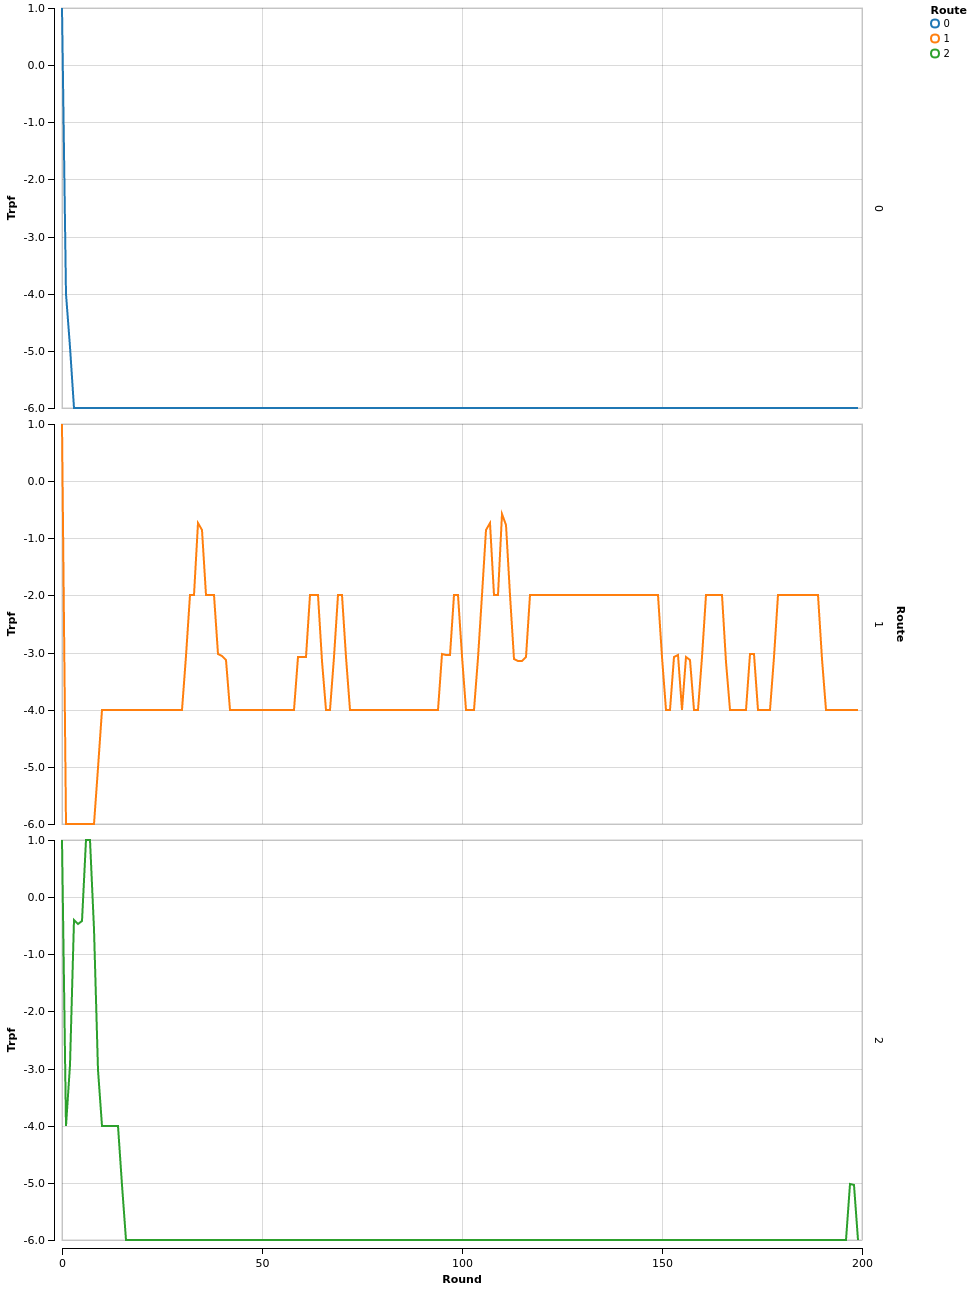

In [12]:
chart = Chart(data).mark_line().encode(x='Round:Q', y='Trpf:Q', color='Route:N', row='Route:N')
chart.configure_cell(height=400, width=800)